# Tuning the Best CNN Models #

In this notebook, I will select the top three best models and tune their hyperparameters to get the best fit.

| Model | Accuracy |
| ---- | ---- |
| LogisticRegression | 0.792 | 
| KNeighborsClassifier | 0.750 | 
| SVC | 0.715 | 
| LinearSVC | 0.741 | 
| SGDClassifier | 0.359 | 
| DecisionTreeClassifier | 0.803| 
| RandomForestClassifier | 0.853 | 
| BaggingClassifier | 0.822 | 
| GradientBoostingClassifier | 0.786 | 
| AdaBoostClassifier | 0.785 | 

DecisionTree, RandomForest, and Bagging have the best accuracy so these are the ones I will tune.

In [1]:
import pandas as pd
import nltk
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.stem import WordNetLemmatizer 
from nltk import word_tokenize  
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn import tree
from sklearn import ensemble
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error
from math import sqrt

In [2]:
cnn_df = pd.read_excel('../data/interim/cnn_ready_to_code.xlsx').drop(columns=['Unnamed: 0', 'Unnamed: 0.1']).fillna(0)
cnn_df.head()

,identifier,start_snip,end_snip,sentence,cluster,ad_cluster,news_cluster,snip_ad,isad,contributor,...,has_prev_appreciate,has_next_appreciate,has_prev_ahead,has_prev_return,has_prev_after this,has_prev_go away,has_next_good evening,has_prev_applause,has_next_applause,has_prev_tuned
0,CNNW_20190528_060000_CNN_Newsroom_Live,0,60,"now the fastest, most reliable internet can he...",1,0,0,0,1.0,CNNW,...,0,0,0,0,0,0,0,0,0,0
1,CNNW_20190528_060000_CNN_Newsroom_Live,0,60,"that's simple, easy, awesome.",1,0,0,0,1.0,CNNW,...,0,0,0,0,0,0,0,0,0,0
2,CNNW_20190528_060000_CNN_Newsroom_Live,0,60,taxi!,1,0,0,0,1.0,CNNW,...,0,0,0,0,0,0,0,0,0,0
3,CNNW_20190528_060000_CNN_Newsroom_Live,0,60,should i have stopped her?,1,0,0,0,1.0,CNNW,...,0,0,0,0,0,0,0,0,0,0
4,CNNW_20190528_060000_CNN_Newsroom_Live,0,60,save hundreds of dollars a year when you get i...,1,0,0,0,1.0,CNNW,...,0,0,0,0,0,0,0,0,0,0


In [3]:
y = np.array(cnn_df['isad'])
X = cnn_df.drop(columns=['identifier', 'contributor', 'subjects', 'start_time', 'stop_time', 'runtime',
                        'isad']).dropna()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=18)

In [4]:
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'not', 'would', 'say', 'could',
                           '_', 'be', 'know', 'good', 'go', 'get', 'do', 'done', 'try', 'many',
                           'some', 'nice', 'thank', 'think', 'see', 'rather', 'easy', 'easily',
                           'lot', 'lack', 'make', 'want', 'seem', 'run', 'need', 'even', 'right',
                           'line', 'even', 'also', 'may', 'take', 'come', 'hi', 'ha', 'le', 'u', 'wa', 'thi',
                           'to', 'one'])

In [5]:
def clean_sent(sentences):
    for sent in sentences:
        sent = str(sent)
        sent = re.sub('\s+', ' ', sent)  # remove newline chars
        sent = re.sub("\'", "", sent)  # remove single quotes
        sent = re.sub("([\d,\,\./!#$%&\'\":;>\?@\[\]`)(\+])+", "", sent) # remove digits and remove punctuation
        sent = re.sub("([-])+", " ", sent)
        yield(sent)  

In [6]:
corpus_train = list(clean_sent(X_train.sentence.values.tolist()))
corpus_test = list(clean_sent(X_test.sentence.values.tolist()))
corpus_train[:5]

['thats why were working on ways to improve it',
 'theres no changing democrats got a benefit from an unusually large number of voters in  people who hadnt votds in  who turned up and voted predomitly for democrats',
 'otherwise we just wont be able to do business',
 ' she would move to canada if you got elected',
 'do you see it as an unrealistic position']

In [7]:
#lemmatize before vectorizing

class LemmaTokenizer:
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

vect = TfidfVectorizer(tokenizer=LemmaTokenizer(), strip_accents='unicode', stop_words='english', 
                       min_df=2, max_df=0.3, ngram_range=(1,2))

In [8]:
X_train_bow = vect.fit_transform(corpus_train)
X_test_bow = vect.transform(corpus_test)
X_train_bow_df = pd.DataFrame(X_train_bow.toarray())
X_train_joined = X_train.reset_index().join(X_train_bow_df).drop(columns=['index'])
X_test_bow_df = pd.DataFrame(X_test_bow.toarray())
X_test_joined = X_test.reset_index().join(X_test_bow_df).drop(columns=['index'])
X_train_joined = X_train_joined.drop(columns=['sentence'])
X_test_joined = X_test_joined.drop(columns=['sentence'])

C:\Users\linne\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ha', 'le', 'u', 'wa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


In [9]:
def plot_confusion_matrix(model, X, y):
    pred = model.predict(X)
    c=confusion_matrix(y, pred)
    sns.heatmap(c,cmap='BrBG',annot=True)
    print(c)
    plt.show()

In [28]:
params = {'criterion' : ['gini', 'entropy'],
         'splitter' : ['best', 'random'],
         'max_depth' : [10, 50, 75, 100, 200],
         'min_samples_split': [2, 5, 10]}
dtc = tree.DecisionTreeClassifier(random_state=18)
cv = GridSearchCV(dtc, params)
cv.fit(X_train_joined, y_train)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test_joined, y_test)))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Accuracy: 0.8116666666666666
Tuned Model Parameters: {'criterion': 'entropy', 'max_depth': 100, 'min_samples_split': 5, 'splitter': 'random'}


[[1906  240]
 [ 325  529]]


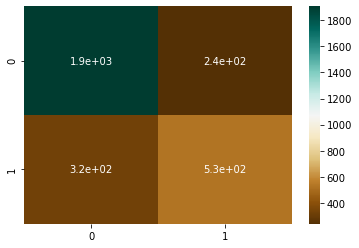

In [29]:
plot_confusion_matrix(cv, X_test_joined, y_test)

In [ ]:
rfc = ensemble.RandomForestClassifier(criterion='entropy', random_state=18)
params = {'n_estimators': [10, 100, 500, 1000],
         'max_depth' : [10, 50, 100, 200],
         'max_features' : ['sqrt', 'log2', None],
         'min_samples_split': [2, 5, 10]}
cv = RandomizedSearchCV(rfc, params)
#cv = GridSearchCV(rfc, params)
cv.fit(X_train_joined, y_train)


In [33]:
# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test_joined, y_test)))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Accuracy: 0.8576666666666667
Tuned Model Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 200}


[[2052   94]
 [ 333  521]]


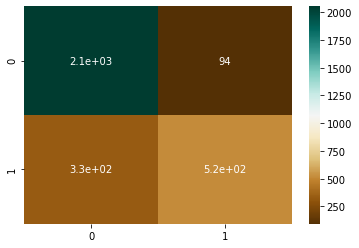

In [34]:
plot_confusion_matrix(cv, X_test_joined, y_test)

In [35]:
rfc = ensemble.RandomForestClassifier(criterion='entropy', n_estimators=100, min_samples_split=2,
                                      max_features='sqrt', random_state=18)
params = {'max_depth' : [150, 200, 300, 500]}
#cv = RandomizedSearchCV(rfc, params)
cv = GridSearchCV(rfc, params)
cv.fit(X_train_joined, y_train)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test_joined, y_test)))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Accuracy: 0.857
Tuned Model Parameters: {'max_depth': 150}


That got worse, so let's say these parameters are the best: 

Tuned Model Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'max_features': 'sqrt', 'max_depth': 200}

In [10]:
bgc = ensemble.BaggingClassifier(random_state=18)
params = {'n_estimators': [10, 100, 500, 1000],
         'max_features' : [0.25, 0.5, 0.75, 1.0]}
cv = RandomizedSearchCV(bgc, params)
cv.fit(X_train_joined, y_train)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test_joined, y_test)))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Accuracy: 0.851
Tuned Model Parameters: {'n_estimators': 1000, 'max_features': 0.25}
